This is a notebook for generating and modling SAGE signal for estimating the SNR needed from the magnet.




$$S(\tau) = $$ \begin{cases}
                               S_0^I \cdot exp(-\tau R_2^*) & \text{if $0<\tau < \frac{TE_{SE}}{2} $} \\
                           S_0^{II} exp(-TE\times(R_2^*-R_2)) \times exp(\tau(2R_2-R_2^*)) & \text{if $\frac{TE_{SE}}{2} < \tau \leq TE_{SE} $}
\end{cases}





In [2]:
using Pkg	
try
    println("If is first time you ran the code. It will take a minute to precompile.")
    @eval using NIfTI; 
    @eval using LsqFit;
    @eval using Printf
    @eval using ArgParse;
    @eval using Statistics;
    @eval using Optim;
    @eval using Plots;
    @eval using LinearAlgebra;
    @eval using StatsPlots
    Pkg.precompile()
catch e
    # not found; install and try loading again
    Pkg.add("NIfTI")
    Pkg.add("LsqFit")
    Pkg.add("Printf")
    Pkg.add("ArgParse")
    Pkg.add("Optim")
    Pkg.add("Plots")
    Pkg.add("LinearAlgebra")
    Pkg.add("StatsPlots")
    @eval using NIfTI; 
    @eval using LsqFit;
    @eval using Printf
    @eval using ArgParse;
    @eval using Statistics;
    @eval using Optim;
    @eval using Plots;
    @eval using LinearAlgebra;
    @eval using StatsPlots

end

using NIfTI; 
using LsqFit;
using Printf
using ArgParse;
using Statistics;
using Optim;
using Plots;

If is first time you ran the code. It will take a minute to precompile.


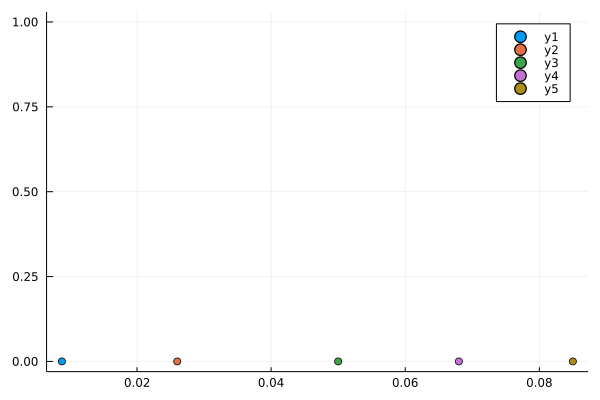

In [3]:
te1=0.0088;
te2=0.026;
te3=0.050;
te4=0.068;
te5=0.085;
echo_times = [te1 te2 te3 te4 te5];

N = 1000;
S₀ᴵ = 2000;
S₀ᴵᴵ = 0;
R₂ˢᵗᵃʳ = 30.0;
R₂ = 15;


function SAGE_biexp4p_d(te,p)
   
    tn=te;
    TE=te[end];
    SI_sage = zeros(size(tn));
    # %Create piece-wise function based on Schmiedeskamp H et al. MRM 2012
    # %67:378-388
    ind1 = findall(x->x<TE/2,tn)
    ind2 = findall(x->x>TE/2,tn)

    # R₂star = p[2]
    # R₂ = p[3]
    # S₀I=p[1]
    # S₀II=p[4]
    
    SI_sage[ind1] = p[1].*exp.(-tn[ind1].*p[3]);
    SI_sage[ind2] = (p[2]).*exp.(-TE*(p[3]-p[4])).*exp.(-tn[ind2]*(2*p[4]-p[4]));
    return SI_sage
end


function SAGE_biexp4p_NS(te,p)
    τ=te;
    TEₛₑ = τ[end];
    SI_sage = similar(τ);
    for (n,ii) in enumerate(τ)
        if ii<TEₛₑ/2
            SI_sage[n] = p[1]*exp(-ii*p[3]);
        else
            SI_sage[n] = (p[2])*exp(-TEₛₑ*(p[3]-p[4]))*exp(-ii*(2*p[4]-p[3]));
        end
    end
    return SI_sage
end


pred = SAGE_biexp4p_d(echo_times,[S₀ᴵ S₀ᴵᴵ R₂ˢᵗᵃʳ R₂])
pred2 = SAGE_biexp4p_NS(echo_times,[S₀ᴵ S₀ᴵᴵ R₂ˢᵗᵃʳ R₂])

# scatter(echo_times,pred)
# scatter!(echo_times,pred2)
scatter(echo_times,pred-pred2)

In [4]:
echos=echo_times

te1=echos[1];
te2=echos[2];
te3=echos[3];
te4=echos[4];
te5=echos[5];

Y = zeros(5,4);
Y[1,:] = [1  0  -te1 0 ]
Y[2,:] = [1  0  -te2 0 ]
Y[3,:] = [1 -1  -te5+te3 te5-2*te3 ]
Y[4,:] = [1 -1  -te5+te4 te5-2*te4 ]
Y[5,:] = [1 -1  0 -te5 ]
Y

5×4 Matrix{Float64}:
 1.0   0.0  -0.0088   0.0
 1.0   0.0  -0.026    0.0
 1.0  -1.0  -0.035   -0.015
 1.0  -1.0  -0.017   -0.051
 1.0  -1.0   0.0     -0.085

In [6]:
Sig = pred'
SNR=50;
N = 1000

function f()
    noisy_sig = abs.(randn(size(Sig))+Sig)./SNR .* (pred[1] + pred[3])
    S=similar(noisy_sig)
    for (n,ii) = enumerate(noisy_sig)
        S[n] = log(ii)
    end

    A = Y \ S
    return A
end
out = zeros(N,4)
for ii in 1:N
    out[ii,:] = f()
end

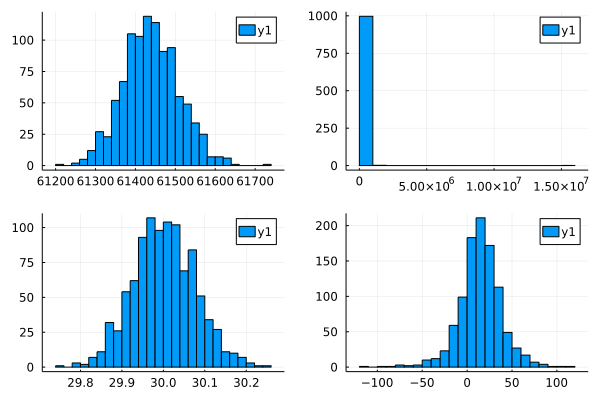

In [7]:
using StatsPlots, StatsPlots.PlotMeasures

S01 = exp.(out[:,1]);
S02= exp.(out[:,2]);
R2s = out[:,3];
R2 = out[:,4];

p1 = histogram(S01;bins =25)
p2 = histogram(S02;bins =25)
p3 = histogram(R2s;bins =25)
p4 = histogram(R2;bins =25)
l = @layout [a  b; c  d]
plot(p1, p2, p3,p4, layout = l)

In [8]:

function nlsfit(f::Function, xvalues::Array{Float64},yvalues::Array{Float64},guesses::Array{Float64})
    fit = curve_fit(f,xvalues,yvalues,guesses,lower=[0, 0, 0.0, 0],upper=[Inf, Inf, 200, 200];autodiff=:finiteforward)
    return fit.param
end

function f2()
    noisy_sig = abs.(randn(size(Sig))+Sig)./SNR .* (pred[1] + pred[3])

    p0=[S₀ᴵ S₀ᴵᴵ R₂ˢᵗᵃʳ R₂];
    x=zeros(5)
    y=zeros(5)
    for (n,ii) in enumerate(echos)

        x[n]=echos[n]
        y[n]=noisy_sig[n]
    end
    x0=zeros(4)
    for (n,ii) in enumerate(p0)
        x0[n]=x0[n]
    end
    A = nlsfit(SAGE_biexp4p_NS,x,y,x0)
    return A
end

out2 = zeros(N,4)
for ii in 1:N
    out2[ii,:] = f2()
end


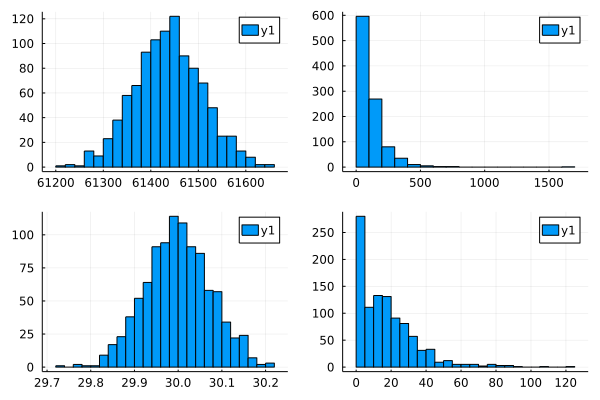

In [9]:
using StatsPlots, StatsPlots.PlotMeasures

S01 = (out2[:,1]);
S02= (out2[:,2]);
R2s = out2[:,3];
R2 = out2[:,4];

p1 = histogram(S01;bins =25)
p2 = histogram(S02;bins =25)
p3 = histogram(R2s;bins =25)
p4 = histogram(R2;bins =25)
l = @layout [a  b; c  d]
plot(p1, p2, p3,p4, layout = l)

Modeling DSC

Quarles CC, Gochberg DF, Gore JC, Yankeelov TE. A theoretical framework to model DSC-MRI data acquired in the presence of contrast agent extravasation. Phys Med Biol. 2009 Oct 7;54(19):5749-66. doi: 10.1088/0031-9155/54/19/006. Epub 2009 Sep 4. PMID: 19729712; PMCID: PMC2767268.

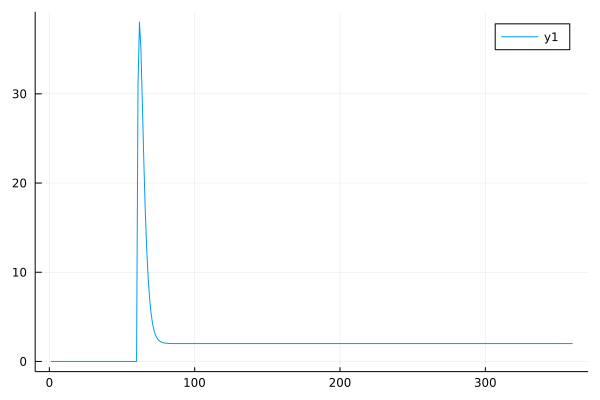

In [10]:
# Setting constants for modeling
A = 200.0 # M
B = 2   # M
C = 1   #unitless
tAIF = 1:300 #time
t = 1:360 
tp = 2.0  # s

CAIFt = zeros(360);
for (n,ii) in enumerate(61:360)
    CAIFt[ii] = A*(tAIF[n]/tp^2).*exp(-tAIF[n]/tp) + B*(1-exp(-C*tAIF[n]/tp));
end
plot(CAIFt)

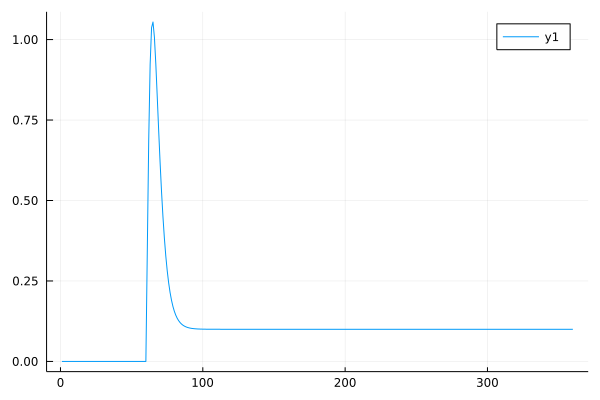

In [11]:
using DSP
# normal tissue
# Initialize all variables
CBV = 0.04; 
CBF = 60/6000; #normal tissue
flip = 90; 
R10 = 1/1.44; 
R20 = 1/0.035;  #normal tissue
PS = 0; #normal tissue
rho = 1.04    # Density
kH = 0.733 # Hematocrit
vp = CBV; #?

# Define vpCpt (product of blood volume fraction and blood plasma CA concentration)
# vpCpt = similar(CAIFt)
# for (n,ii) in enumerate(1:360)
#     vpCpt[n] = (rho/kH) * CBF * conv(CAIFt[n], exp(-t[n]/(CBV/CBF)));
#     vpCpt = vpCpt(1:maximum(t));
# end
vpCpt = (rho/kH) * CBF * conv(CAIFt, exp.(-t./(CBV/CBF)));
vpCpt = vpCpt[1:maximum(t)]
plot(vpCpt)

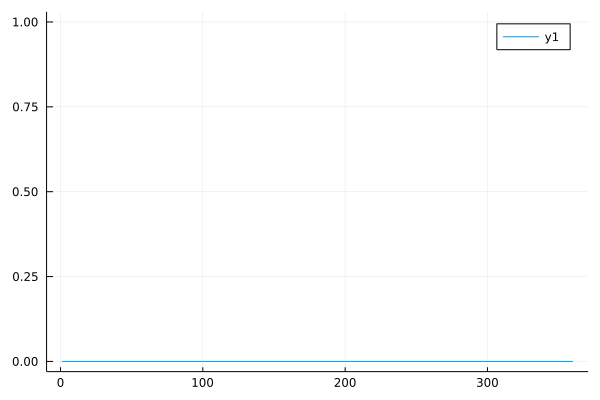

In [12]:
Cpt = vpCpt./vp;

E = 1 - exp(-PS/(CBF*(1-kH)));
Ktrans = E*CBF*rho*(1-kH);
ve = 0.25; 

# Define veCet (from Kety-Tofts model)
veCet = (Ktrans) .* conv(CAIFt, exp.(-(Ktrans/ve).*t));
veCet = veCet[1:maximum(t)];

plot(veCet)


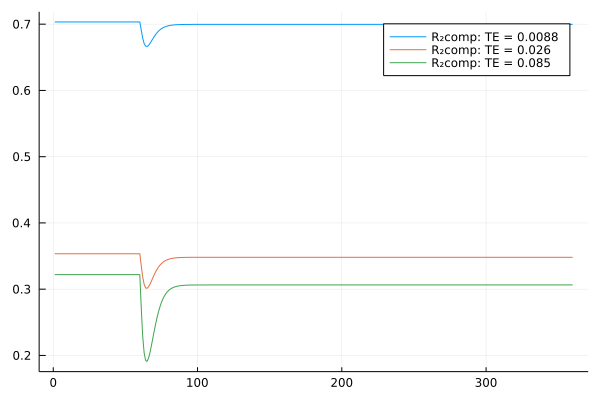

In [52]:
Cet = veCet/ve;
TE1 = echos[1]; 
TE2 = echos[2]; 
TE5 = echos[5];
TR = 1;
r1 = 3.9; 
r2 = 5.3;
S0 = 1000
vp = CBV
vi = 1 - vp - ve; 
Kp = 0.55
Ke = 0.5*Kp

# %Define signal intensity
R1micro = (r1.*(veCet .+ vpCpt));
R1comp=similar(R1micro)
for (n,ii) in enumerate(1:length(R1micro))
    R1comp[n] = S0*sin(flip*pi/180)*(1-exp(-TR.*(R1micro[n]+R10))) / (1-cos(flip*pi/180)*exp.(-TR*(R1micro[n]+R10)));
end

R2micro = (r2*(veCet + vpCpt));
R2meso = (Kp*vp*(ve*abs.(Cpt - Cet)+vi*Cpt) + Ke*vi*veCet);
R20 = 1/0.025;  #normal tissue
R20s = 1/0.075;  #normal tissue
R2comp_TE1=similar(R2meso)
R2comp_TE2=similar(R2meso)
R2comp_TE5=similar(R2meso)
for (n,ii) in enumerate(1:length(R2comp_TE1))
    R2comp_TE1[n] = exp(-TE1 * (R2micro[n] + R2meso[n] + R20));
    R2comp_TE2[n] = exp(-TE2 * (R2micro[n] + R2meso[n] + R20));
    R2comp_TE5[n] = exp(-TE5 * (R2micro[n] + R2meso[n] + R20s));
end

# plot(R1comp,label="R₁comp")
plot(R2comp_TE1,label="R₂comp: TE = $TE1")
plot!(R2comp_TE2,label="R₂comp: TE = $TE2")
plot!(R2comp_TE5,label="R₂comp: TE = $TE5")

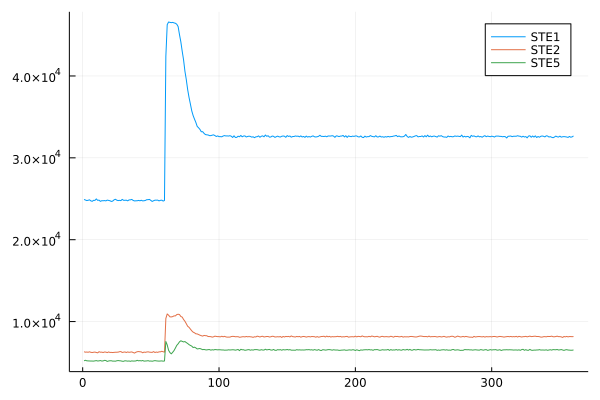

In [53]:
St_TE1 = R1comp .* R2comp_TE1 
St_TE2 = R1comp .* R2comp_TE2
St_TE5 = R1comp .* R2comp_TE5

SNR = 10
St_TE1 = abs.(randn(size(St_TE1))+St_TE1)./SNR .* (St_TE1[1] + St_TE1[3])
St_TE2 = abs.(randn(size(St_TE2))+St_TE2)./SNR .* (St_TE2[1] + St_TE2[3])
St_TE5 = abs.(randn(size(St_TE5))+St_TE5)./SNR .* (St_TE5[1] + St_TE5[3])

plot(St_TE1,label="STE1")
plot!(St_TE2,label="STE2")
plot!(St_TE5,label="STE5")

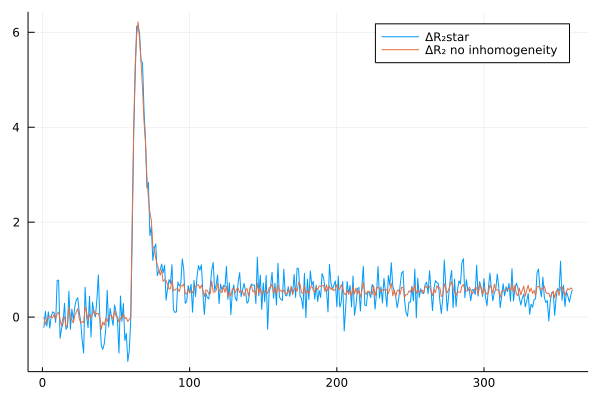

In [54]:
gd_tp = 30
pk_tp = 50
ΔR₂star = similar(St_TE1)
for (n,ii) = enumerate( 1:length(St_TE1))
    ΔR₂star[n] = 1/(TE2-TE1) * (log(St_TE1[n]/St_TE2[n]) - log(mean(St_TE1[gd_tp:pk_tp]) / mean(St_TE2[gd_tp:pk_tp])))
end

ΔR₂ = similar(St_TE1)
Sₜₑ0 = St_TE1.*(St_TE1./St_TE2).^(TE1/(TE2-TE1))

for (n,ii) = enumerate( 1:length(St_TE1))
    ΔR₂[n] = 1/(TE5) * (log(Sₜₑ0[n]/St_TE5[n]) - log(mean(Sₜₑ0[gd_tp:pk_tp]) / mean(St_TE5[gd_tp:pk_tp])))
end

plot(ΔR₂star,label="ΔR₂star")
plot!(ΔR₂,label="ΔR₂ no inhomogeneity")